In [1]:
import holidays
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings('ignore')

### Data preparation

In [2]:
df = pd.read_csv('data/covid19-clean.csv')
df['Date'] = df['Date'].apply(lambda row: datetime.strptime(row, "%d %B %Y "))

In [3]:
data = df[['Date', 'Recovered']]
data.columns = ['ds', 'y']

In [4]:
holidays_pl = pd.DataFrame(holidays.PL(years = 2020), index = [0]).T.reset_index()
holidays_pl.columns = ['ds', 'holiday']
holidays_pl['lower_window'] = -1
holidays_pl['upper_window'] = 3

# Modeling

### Model creation

In [5]:
model_args = {
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 0.05,
    'holidays_prior_scale': 0.01,
    'weekly_seasonality': 8,
    'yearly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_range': 0.8,
    'holidays': holidays_pl,
    'mcmc_samples': 1000
}

In [6]:
model = Prophet(**model_args)
model.add_seasonality(name = '2-weekly', period = 14, fourier_order = 8, prior_scale = 0.05)
model.fit(data[40:])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
future = model.make_future_dataframe(periods = 1)
forecast = model.predict(future)

In [8]:
forecast = pd.merge(forecast, model.history[['ds', 'y']], on='ds')
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,y,yhat,yhat_lower,yhat_upper
65,2020-06-11,285.0,274.370063,182.714494,371.375993
66,2020-06-12,109.0,216.763963,118.882031,307.310028
67,2020-06-13,299.0,297.304052,202.710897,388.810514
68,2020-06-14,122.0,224.939828,130.196288,320.139160
69,2020-06-15,157.0,203.679930,115.671791,293.844191
70,2020-06-16,271.0,267.815554,174.681668,357.728925
71,2020-06-17,267.0,305.951099,219.052598,397.679458
72,2020-06-18,396.0,291.060293,199.434172,385.988685
73,2020-06-19,381.0,291.639702,203.658195,383.325689
74,2020-06-20,483.0,299.889287,204.434780,393.376075


### Model explanation

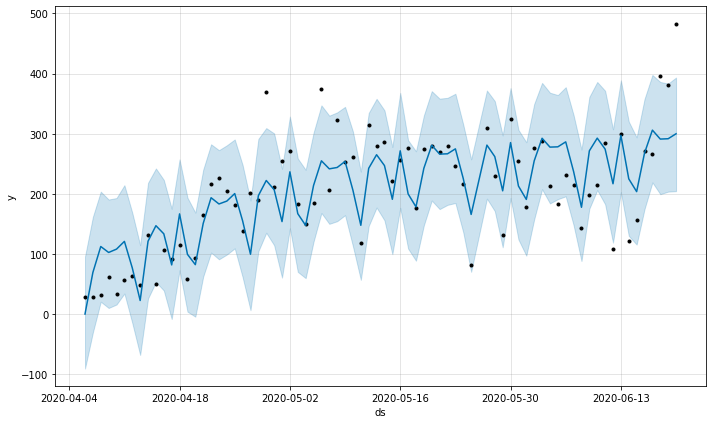

In [9]:
fig = model.plot(forecast)

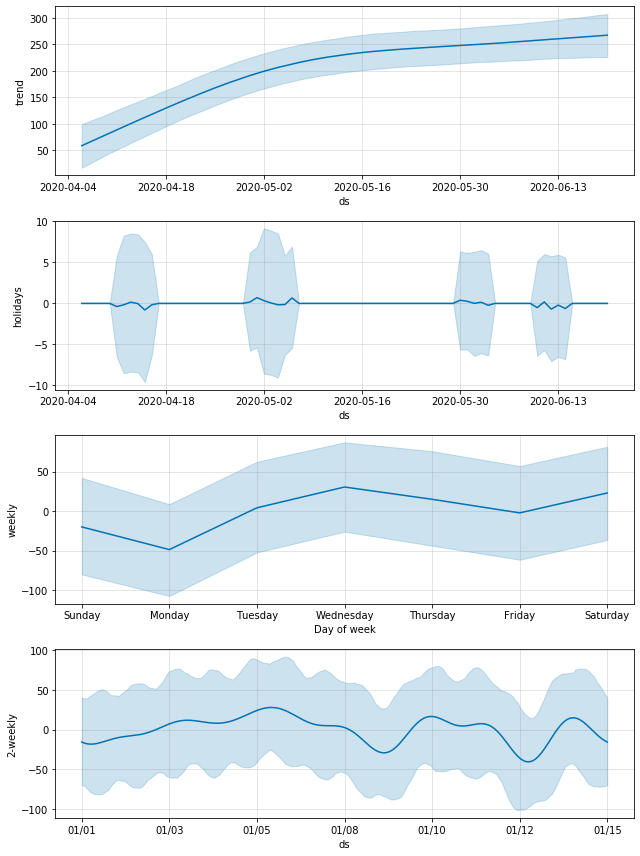

In [10]:
fig = model.plot_components(forecast, uncertainty=True)

### Model performance

In [11]:
results = cross_validation(model, initial = '69 days', horizon = '1 day', period = '1 day')
metrics = performance_metrics(results)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-14 00:00:00 and 2020-06-19 00:00:00


In [12]:
results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-15,173.330745,95.620668,256.575312,157.0,2020-06-14
1,2020-06-16,223.959888,146.571843,302.820071,271.0,2020-06-15
2,2020-06-17,275.187059,198.084273,351.523095,267.0,2020-06-16
3,2020-06-18,231.033400,150.112282,307.333380,396.0,2020-06-17
4,2020-06-19,249.177896,167.029612,330.804284,381.0,2020-06-18
5,2020-06-20,252.751736,166.713173,344.304860,483.0,2020-06-19


In [13]:
metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,16691.967055,129.197396,99.765814,0.257923,0.259785,0.5


### Tomorrow prediction

In [15]:
np.round(forecast.iloc[-1]['yhat']).astype(int)

300